<a href="https://colab.research.google.com/github/MutianWang/novel-cell/blob/main/human/gan_pca200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novel Cells Generation

In [1]:
import time
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/My Drive/Colab Notebooks/Brain Cell/data/'

## Preprocessing

In [ ]:
meta = pd.read_csv(path+'meta.csv', header=0)
cols_glut = meta[meta['class']=='Glutamatergic']['sample_name']
cols_non = meta[meta['class']=='Non-neuronal']['sample_name']
cols_gaba = meta[meta['class']=='GABAergic']['sample_name']

In [ ]:
def normalize(df):
    # counts per million
    df = df.div(df.sum(axis=1), axis=0) * 10**6
    df = df.fillna(0)
    return df

In [ ]:
def read_expression(file1, file2, usecols):
    # point-wise addition of exon and intron tables
    reader1 = pd.read_csv(file1, header=0, usecols=usecols, chunksize=1000)
    reader2 = pd.read_csv(file2, header=0, usecols=usecols, chunksize=1000)

    df = reader1.get_chunk() + reader2.get_chunk()
    for i in range(1, 51):
        df = pd.concat([df, reader1.get_chunk() + reader2.get_chunk()])
        if i%10==0:
            print('{}/50'.format(i))

    return df.transpose()

In [ ]:
exp_glut = read_expression(path+'exon.csv', path+'intron.csv', cols_glut) # 10525 * 50281
exp_glut = exp_glut.sample(5000-914) # 4086 * 50281
exp_glut = normalize(exp_glut)
np.save(path+'exp_glut', exp_glut)
del exp_glut

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_non = read_expression(path+'exon.csv', path+'intron.csv', cols_non) # 914 * 50281
exp_non = normalize(exp_non)
np.save(path+'exp_non', exp_non)
del exp_non

10/50
20/50
30/50
40/50
50/50


In [ ]:
exp_gaba = read_expression(path+'exon.csv', path+'intron.csv', cols_gaba) # 4164 * 50281
exp_gaba = normalize(exp_gaba)
np.save(path+'exp_gaba', exp_gaba)
del exp_gaba

10/50
20/50
30/50
40/50
50/50


In [ ]:
# first 4086 are Glutamatergic, last 914 are Non-neuronal
exp_train = np.concatenate([np.load(path+'exp_glut.npy'), 
                            np.load(path+'exp_non.npy')], axis=0)
np.save(path+'exp_train', exp_train)

## Dimension Reduction

In [4]:
pipe = Pipeline([('scaler1', StandardScaler()), ('pca', PCA(n_components=200)), ('scaler2', MinMaxScaler())])

In [5]:
exp_train = np.load(path+'exp_train.npy')
exp_train = pipe.fit_transform(exp_train)
np.save(path+'exp_train_pca200', exp_train)
del exp_train

In [6]:
pickle.dump(pickle.dumps(pipe), open(path+'pipe200', 'wb'))

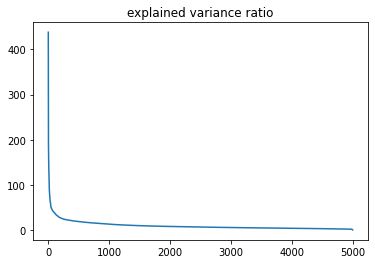

In [ ]:
# set n_components=5000 to plot this graph
#plt.plot(pipe['pca'].explained_variance_);
#plt.title('explained variance ratio');

In [7]:
exp_test = np.load(path+'exp_gaba.npy')
exp_test = pipe.transform(exp_test)
np.save(path+'exp_test_pca200', exp_test)
del exp_test

## GAN

In [4]:
random.seed(44)
np.random.seed(44)
tf.random.set_seed(44)

In [5]:
exp_train = np.load(path+'exp_train_pca200.npy')

In [6]:
# oversample the non-neuronal cells
#exp_train = np.concatenate([exp_train, exp_train[-914:]], axis=0)

# undersample the glutamatergic cells
exp_train = exp_train[2000:]

In [7]:
BATCH_SIZE = 1000
dataset = tf.data.Dataset.from_tensor_slices(exp_train).shuffle(100).batch(BATCH_SIZE)

In [8]:
dimension = exp_train.shape[1]

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=True, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # sigmoid function will make the range [0,1]
    model.add(layers.Dense(dimension, use_bias=True, activation='sigmoid'))

    return model

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=True, input_shape=(dimension,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(128, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1))

    return model

In [30]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [31]:
#generator.summary()

In [32]:
#discriminator.summary()

In [33]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [34]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [35]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [36]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 128])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    if random.random() > 0.2:
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [37]:
def train(dataset, epochs, delta):
    loss_hist = []
    gen_loss_hist = []
    disc_loss_hist = []
    for epoch in range(epochs):
        start = time.time()

        gen_loss = 0
        disc_loss = 0
        for data in dataset:
            loss1, loss2 = train_step(data)
            gen_loss += loss1
            disc_loss += loss2

        if (epoch+1)%20 == 0:
            print('Time for epoch {} is {} sec. Loss is {}'.format(epoch + 1, time.time()-start, gen_loss+disc_loss))
        
        loss_hist.append(gen_loss+disc_loss)
        gen_loss_hist.append(gen_loss)
        disc_loss_hist.append(disc_loss)
        if epoch > 2:
            if abs(loss_hist[-1] - loss_hist[-2]) < delta and abs(loss_hist[-2] - loss_hist[-3]) < delta:
                print('Final Loss is {}'.format(loss_hist[-1]))
                return loss_hist, gen_loss_hist, disc_loss_hist

    print('Final Loss is {}'.format(loss_hist[-1]))
    return loss_hist, gen_loss_hist, disc_loss_hist

In [38]:
hist = train(dataset, epochs=1000, delta=0.005)

Time for epoch 20 is 0.12547898292541504 sec. Loss is 48.07190704345703
Time for epoch 40 is 0.16681694984436035 sec. Loss is 20.681312561035156
Time for epoch 60 is 0.1279752254486084 sec. Loss is 23.160661697387695
Time for epoch 80 is 0.14161944389343262 sec. Loss is 12.103748321533203
Time for epoch 100 is 0.1308116912841797 sec. Loss is 16.763628005981445
Time for epoch 120 is 0.13037991523742676 sec. Loss is 10.472332954406738
Time for epoch 140 is 0.13063263893127441 sec. Loss is 15.866622924804688
Time for epoch 160 is 0.14864015579223633 sec. Loss is 14.095038414001465
Time for epoch 180 is 0.13883137702941895 sec. Loss is 15.556325912475586
Time for epoch 200 is 0.11742806434631348 sec. Loss is 13.464205741882324
Time for epoch 220 is 0.15723252296447754 sec. Loss is 14.328438758850098
Time for epoch 240 is 0.1524498462677002 sec. Loss is 13.422944068908691
Time for epoch 260 is 0.11910200119018555 sec. Loss is 9.13667106628418
Time for epoch 280 is 0.14774036407470703 sec. L

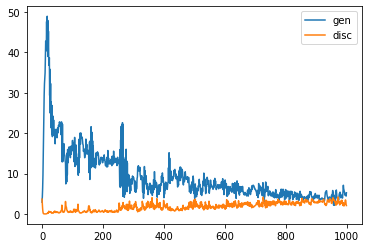

In [39]:
plt.plot(hist[1]);
plt.plot(hist[2]);
plt.legend(['gen', 'disc']);

In [40]:
exp_gen = generator(tf.random.normal([1000,128]))

In [23]:
#np.save(path+'exp_gen200', exp_gen)

## Evaluation

### PCA + Visualization

In [24]:
pipe = pickle.loads(pickle.load(open(path+'pipe200', 'rb')))

In [25]:
tmat = pipe['pca'].components_.transpose()

In [26]:
exp_glut = pipe['scaler1'].transform(np.load(path+'exp_glut.npy')) @ tmat[:, :2]
exp_non = pipe['scaler1'].transform(np.load(path+'exp_non.npy')) @ tmat[:, :2]
exp_gaba = pipe['scaler1'].transform(np.load(path+'exp_gaba.npy')) @ tmat[:, :2]

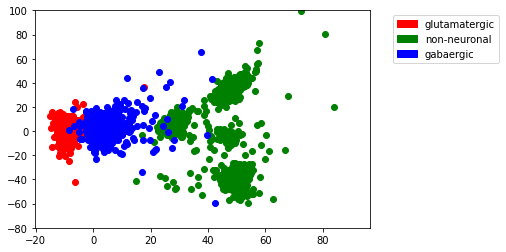

In [27]:
# red: glutamatergic
x, y = list(zip(*exp_glut[:1000]))
plt.scatter(x, y, c='r', alpha=1)
# green: non-neuronal
x, y = list(zip(*exp_non[:1000]))
plt.scatter(x, y, c='g', alpha=1)
# blue: gabaergic
x, y = list(zip(*exp_gaba[:1000]))
plt.scatter(x, y, c='b', alpha=1)

#plt.xlim(-2, 2);
plt.ylim(-80, 100);
patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
plt.legend(handles=[patch1, patch2, patch3], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()

In [41]:
exp_gen = pipe.inverse_transform(exp_gen)
exp_gen = pipe['scaler1'].transform(exp_gen) @ tmat[:, :2]

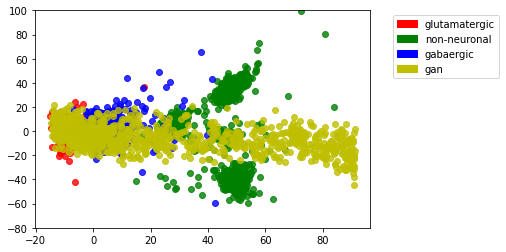

In [42]:
# red: glutamatergic
x, y = list(zip(*exp_glut[:1000]))
plt.scatter(x, y, c='r', alpha=0.8);
# green: non-neuronal
x, y = list(zip(*exp_non[:1000]))
plt.scatter(x, y, c='g', alpha=0.8);
# blue: gabaergic
x, y = list(zip(*exp_gaba[:1000]))
plt.scatter(x, y, c='b', alpha=0.8);
# yellow: gan
x, y = list(zip(*exp_gen[:1000]))
plt.scatter(x, y, c='y', alpha=0.8);

#plt.xlim(-10, 10);
plt.ylim(-80, 100);
patch1 = mpatches.Patch(color='r', label='glutamatergic');
patch2 = mpatches.Patch(color='g', label='non-neuronal');
patch3 = mpatches.Patch(color='b', label='gabaergic');
patch4 = mpatches.Patch(color='y', label='gan');
plt.legend(handles=[patch1, patch2, patch3, patch4], 
           loc='upper right', bbox_to_anchor=(1.4, 1));
plt.show()